## Demo for project 1

In [19]:
import torch
import torchvision

### Define dataset and dataloader

In [29]:
%load_ext autoreload
%autoreload 2

from dataset import load_dataset

trainset, valset = load_dataset(train=True)
testset = load_dataset(train=False)

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
print(valloader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 100/100 [00:00<00:00, 176231.26it/s]


Length of new inputs: 780


100%|██████████| 100/100 [00:00<00:00, 135869.91it/s]

Length of new inputs: 780


### Check dataset and dataloader

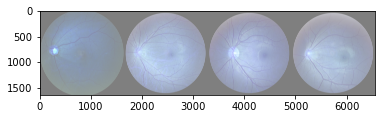

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # The data need to be normalized and unnormalized to keep the same
    # img = img / 255
    # img = img / 2 + 0.5     # unnormalize

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(valloader)
images, targets, _ = next(dataiter)
# print(type(images))

temp_image = torchvision.utils.make_grid(images)


# show images
imshow(torchvision.utils.make_grid(images))

### Define a model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

### Define loss function and optimizer

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train network

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, target) in enumerate(trainloader):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')

### Save model

In [ ]:
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

### Test your model performance

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

net.load_state_dict(torch.load(PATH))
dscs = []

with torch.no_grad():
    for data in testloader:
        images, targets, names = data
        
        outputs = net(images)
        
        for idx, name in enumerate(names):
            output_np = torch.argmax(outputs[idx], dim=0).cpu().numpy()
            binary_output = np.array(output_np)
            target_np = targets[idx].cpu().numpy().astype(np.uint8)
            
            target_1d = np.reshape(target_np, (-1, 1))
            pred_1d = np.reshape(binary_output, (-1, 1))

            accuracy = accuracy_score(target_1d, pred_1d)
            dsc = f1_score(target_1d, pred_1d)
            
            dscs.append(dsc)

dsc_test = np.mean(dscs)
print('Dsc of test set:', dsc_test)